Lone Hits Analysis
========================


[struttura dati straxen](https://straxen.readthedocs.io/en/latest/reference/datastructure.html)

è comodo usare **get_iter** per iterare sui vari chunck, si può chiamare anche più di un target però devono essere dello stesso tipo (guardare struttura dati); importante l'opzione **keep_column**

In [7]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [8]:
st = straxen.contexts.xenonnt_online()

In [9]:
st.context_config['check_available'] = ('raw_records','pulse_counts','peaklets','lone_hits')

In [10]:
runs = st.select_runs(available=('lone_hits'),run_mode='*selftrigger*')

Checking data availability: 100%|██████████| 4/4 [03:34<00:00, 53.61s/it]


In [11]:
runs

,name,number,mode,start,end,tags,livetime,tags.name,peaklets_available,raw_records_available,pulse_counts_available,lone_hits_available
20,007178,7178,xenonnt_selftrigger_commissioning,2020-04-01 08:55:05.699,2020-04-01 09:10:08.602,,00:15:02.903000,NaN,True,False,True,True
21,007179,7179,xenonnt_selftrigger_commissioning,2020-04-01 09:10:41.945,2020-04-01 09:25:42.263,,00:15:00.318000,NaN,True,False,True,True
47,007205,7205,xenonnt_selftrigger_commissioning,2020-04-09 12:51:46.196,2020-04-09 12:55:33.618,,00:03:47.422000,NaN,True,False,True,True
78,007236,7236,xenonnt_selftrigger_commissioning,2020-04-17 17:36:57.991,2020-04-17 18:36:59.973,,01:00:01.982000,NaN,True,False,True,True
79,007237,7237,xenonnt_selftrigger_commissioning,2020-04-17 18:37:27.301,2020-04-17 19:37:29.723,,01:00:02.422000,NaN,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1289,008447,8447,xenonnt_selftrigger_commissioning_lowe,2020-06-28 07:26:33.785,2020-06-28 08:26:35.128,,01:00:01.343000,NaN,True,False,True,True
1290,008448,8448,xenonnt_selftrigger_commissioning_lowe,2020-06-28 08:26:49.213,2020-06-28 09:26:49.586,,01:00:00.373000,NaN,True,False,True,True
1291,008449,8449,xenonnt_selftrigger_commissioning_lowe,2020-06-28 09:27:03.678,2020-06-28 10:27:04.702,,01:00:01.024000,NaN,True,False,True,True
1292,008450,8450,xenonnt_selftrigger_commissioning_lowe,2020-06-28 10:27:18.796,2020-06-28 11:27:20.190,,01:00:01.394000,NaN,True,False,True,True


In [12]:
st.data_info('lone_hits')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,area,float32,Integral [ADC x samples]
5,left,int16,Index of sample in record in which hit starts
6,right,int16,Index of first sample in record just beyond hi...
7,left_integration,int16,"For lone hits, index of sample in record where..."
8,right_integration,int16,"For lone hits, index of first sample beyond in..."
9,record_i,int32,Internal (temporary) index of fragment in whic...


In [13]:
run_id = '008449'
#lone_hits = st.get_array(run_id,'lone_hits')
pdata = st.get_array(run_id,'lone_hits',max_workers=20,_chunk_number=2)

Text(0, 1, 'counts')

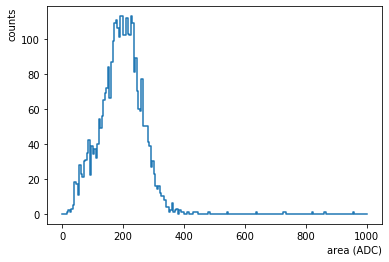

In [8]:
area = Hist1d(pdata['area'][pdata['channel']==1],bins=200,range=(0,1000))
area.plot()
plt.xlabel('area (ADC)', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)

Conversione in carica
-------------------
Il PMT ha in uscita un impulso di corrente che se integrata nel tempo dà la carica rilasciata totale. La variabile **area** utilizzata nell'istogramma precedente, è calcolata sulla waveform somma dei PMT ed è espressa in canali del FADC.

La carica totale che arriva ai PMT si può scrivere come:

$Q=n\cdot e^-=\int_0^{t*} i(t) dt = \int_0^{t*} \frac{V(t)}{R} dt = \dfrac{V_{tot}}{R} \cdot \Delta t$

Per calcolare la carica bisogna tenere conto anche della conversione da canali ADC in Volt.

* $V_{max} = 2.25~$V (ampiezza massima in volt del'ADC)
* $n_{samples} = 2^{14}$ (l'ADC è a 14 bit)
* $R = 50~\Omega$ (impedenza del cavo)
* $\Delta t = 10~$ns (sample width)

$Q= \dfrac{area}{R} \cdot \Delta t\cdot \dfrac{V_{max}}{n_{samples}}$

per calcolare il numero di elettroni basta dividere per la carica dell'elettrone:

$n = \dfrac{Q}{e^-}$

Il gain del PMT si calcola dal picco di Single Photo-Electron (SPE).

In [103]:
def charge(id):
    Z = 50
    e = 1.6021766208e-19
    w = 1e-9
    r = 2.25/2**14
    
    conv = r*w/(Z*1e-12)
    # PMT total charge
    plt.figure(1)
    pmt_charge = Hist1d(pdata['area'][pdata['channel']==id]*conv,
                        bins=200, range=(0,2) )
    #plt.hist(pdata['area'][pdata['channel']==id]*conv,
             #bins=200,range=(0,2),label=f"PMT n. {id}",
            #histtype='step')
    pmt_charge.plot(label=f"PMT n. {id}")
    plt.xlabel('total charge (pC)')
    plt.ylabel('counts', ha='right', y=1)
    plt.legend()
    # gain calculation
    plt.figure(2)
    el_hist, el_bin = np.histogram(pdata['area'][pdata['channel']==id]*conv/e*1e-18,
             bins=200, range=(0,10))
    bin_max = np.where(el_hist > el_hist.max()*0.8)
    gain =np.average(el_bin[bin_max])
    plt.plot(el_bin[1:],el_hist,label=f"PMT n. {id}, gain: {gain:.1f}$\cdot 10^6$")
    plt.xlabel('number of electrons $x10^6$')
    plt.ylabel('counts', ha='right', y=1)
    plt.legend()

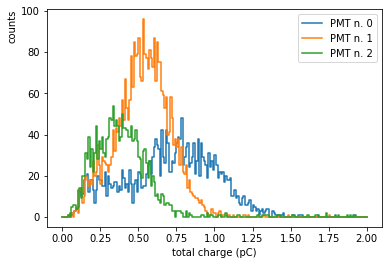

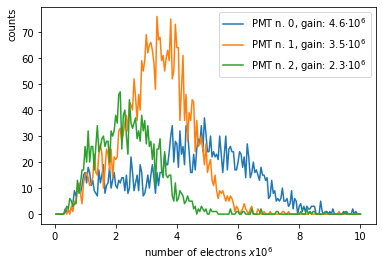

In [104]:
for i in range(3):
    charge(i)